In [ ]:
# import packages
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
from tifffile import imsave

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

"""Align crop images for Changhui and Jie's experiment data using the confocol
Use the gfp signal to preselect the in focus images 
"""
%matplotlib inline
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from scipy.stats import linregress
import scipy.stats
import scipy.signal
import scipy.spatial
import pandas as pd
import numpy as np
import math, re, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
from datetime import datetime
from skimage import filters
import skimage, skimage.io, skimage.feature
from skimage.feature import register_translation
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.feature.register_translation import _upsampled_dft

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import glob
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture

from skimage.measure import label, regionprops

import time as Time
from skimage.morphology import remove_small_objects
from skimage.measure import find_contours
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
import pylab
from skimage.segmentation import flood 
import cv2
import numpy as np
from statistics import stdev 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def getFileList(file_dir_pattern):
    """Get the file lists organized by position, time into dictionary, z stacked images will be appended in as well
    that match the given file_dir_pattern
    Parameters:
    ============
    file_dir_pattern : pattern of the file including the directory
    """
    files = glob.glob(file_dir_pattern)
    image_files = {}
    pattern = re.compile(".*\/.*s(\d+)[t&z](\d+).*") # \d+ 0-9 digit repeats more than once, [t|z]- looks for t or z, *s any charecter that is not a whitespace
    for filename in sorted(files): # keep them sorted 
        #print filename
        match = pattern.match(filename)
        if match:
            pos = match.group(1).zfill(3) # zfill returns on the left and fills with 0
            time = int(match.group(2)) # returns the time
            image_files.setdefault(pos,{}) # .setdefault if key not in dic will make it 
            image_files[pos].setdefault(time, []) # setting the time dictionary as a list so i can append later 
            image_files[pos][time].append(filename)# double dict keys!
    return image_files

def quickaggre(poslist, timelist, dic_images, listype = None, gaus = None):
    """To sum the zstacks of a position or time, takes in multiple times and positions OR a singular time or position
    dic_images- are bf_images, rfp_images or gfp_images. made using Jiashuns getfilelist!
    listype MUST say True or False.
        True = means poslist and timelist must be written as list form: expample ['001', '002'] and [1,217,216] 
            notice that position is written as STRING and timelist is written as INT must be kept!
        False = means poslist and timelist are SINGULAR as such '001' and 217  
            again position is STRING timelist is int
    gaus if True will peform a gausian blur, this is used on GFP! to help remove background noise 
     example to call out one set : quickaggre('006', 100 , gfp_images, False, True)['006'][100 ] """
    aggdic ={}
    if listype is True:# for multiple times and positions 
        for time in timelist:
            for pos in poslist:
                first_stack = np.zeros((len(dic_images[pos][time]), 512, 512)) 
                for i,img in enumerate(dic_images[pos][time]):
                    first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
                    aggdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    if gaus is True:
                        stack = np.sum(first_stack, axis = 0)
                        aggdic[pos][time] = ndimage.gaussian_filter(stack, sigma = 1.5)
                    else:
                        aggdic[pos][time] = np.sum(first_stack, axis = 0) # lets you add all the images together 

    elif listype is None or listype is False: # for just one of the values position or time 
        first_stack = np.zeros((len(dic_images[poslist][timelist]), 512, 512)) 
        for i,img in enumerate(dic_images[poslist][timelist]):
            first_stack[i, :, :] = skimage.io.imread(img,plugin='pil')
            aggdic.setdefault(poslist,{}) # .setdefault if key not in dic will make it 
            if gaus is True:
                stack = np.sum(first_stack, axis = 0)
                aggdic[poslist][timelist] = ndimage.gaussian_filter(stack, sigma = 1.5)
            else:
                aggdic[poslist][timelist] = np.sum(first_stack, axis = 0) # lets you add all the images together 
    
        
    return aggdic


# for Netbf images path
    # this gives you the file path for each netbf that is made in refence to the position and time 
def netbfimages(filepath):
    """using the filpath given it will out put a dictionary that has the position and time in refence to the filepath"""
    dic = {}
    for filename in glob.glob(filepath ):
        file = filename.split('/')[-1] 
        pos = str(0)+file.split('_')[0]
        time = int(file.split('_')[1].replace('.npz', '')) # turning the string to a time 
        dic.setdefault(pos, {})
        dic[pos][time] = filename 

    return dic


# to load in individual netbfs
def quicknetbfagg(posref,timeref, netbf_images):
    """purpuse is to read in a netbf file individually. will be useful if you want to read just one
    posref- must be string 
    timeref - must be interger 
    netbf_images- is the dictionary that contains the file path names
    example = quicknetbfagg('001',1, netbf_images)['001'][1]  """
    
    netdic = {}
    for filename in glob.glob(netbf_images[posref][timeref]):
        file = filename.split('/')[-1] 
        pos = str(0)+file.split('_')[0]
        time = int(file.split('_')[1].replace('.npz', '')) # turning the string to a time 
        if (pos == posref) & (time == timeref):
            data =  np.load(str(filename))
            data = data['pixels']
            first_stack = np.zeros((data.shape[0], 512, 512)) # making file for zstack 
            for i in range(0,data.shape[0],1):
                first_stack[i, :, :] = data[i, :,:,1]
                netdic.setdefault(pos,{}) # .setdefault if key not in dic will make it 
                    # normalizing the zstack images
                netdic[pos][time] = np.sum(first_stack, axis = 0) 
 
    return netdic

def backsub(background, dataframe):
    'for background normalizations'
    dfmerge = pd.DataFrame(index = background.index)
    for col in background.columns:
        colcell = 'pos_' +str(col)+'_'
        collist = dataframe.columns.str.startswith(colcell)
        df1 = dataframe.loc[:,collist]
        df2 = df1.sub(background[col], axis='index')
        dfmerge = dfmerge.merge(df2, on = 'time', how = 'outer')
        dfmerge.columns.name = 'position' # need to add position back to all column names 
    return dfmerge

# to load files into a dictionary format 

# files you want to use 
import pickle
import bz2

# add the files you want
listfiles = ['rfpsumdf_','gfpsumdfori_', 'r2timedf_', 'areamaskdf_',
            'volumedf_', 'gfpGMmaxdfori_', 'infodf_','backmeandfgfp_',\
             "backmeanlszstackgfp_", 'volume5gfp_', 'backmedianlszstackgfp_'] # 'gfpsumzstackori_'
# 'bay5zstack_'

def makedatadic(listfiles, date, outfilename, normalize = True):
    '''purpose is to place my dataframe in a dictonary so that I can use it later 
    listfiles - this has a list of the files you want have to add _ as it i staken
    date-the date of where it is stored
    outfilename- the file path '''
    dic = {}
    for datafile in listfiles:
        try:
            namefile = datafile.split('_')[0]

            file = outfilename +str(datafile) +str(date)+".pkl"
            with open(file,'rb')\
                as data:
                dic[namefile] = pickle.load(data)
    
        except:
            pass
        if normalize is True:
            try:
 
                for key in list(dic.keys()):# making a new df that has gfp normalized 

                    
                    if key.startswith('gfp') and not key.endswith('backsub'): # to get only those with gfp but not repeat hence backsub
                        newkey = str(str(key)+'backsub')
                        dic[newkey] = backsub(dic['backmeandfgfp'], dic[key])

                    if key.startswith('rfp') and not key.endswith('backsub') : # normalizing and making a new df that has RFP removed 
                        newkey = str(str(key)+'backsub')
                        dic[newkey] = backsub(dic['backmeandfgfp'], dic[key])
            except:
                pass
 
    return dic 


In [ ]:
def addstraintocol (df1, r2timedf1, filterpos = None):
    """purpose is to add strain name
    example :
    addstraintocol(gfpsumdf , r2timedf_11_8_19 , use)
    or 
    (gfpsumdf , r2timedf_11_8_19 )
    df = gfpsumdf_11_21_19, columns must have the position 
    r2timedf = r2timedf_11_21_19 on the rows on the position is the matching columns 
    filterpos = it is a filtered set of positions should be in list format """
    df = df1.copy()
    r2timedf = r2timedf1.copy()
    if 'name' not in r2timedf.columns:
        r2timedf['name'] = r2timedf['position'].astype(str) + '_'+r2timedf['strain'].astype(str)
    if filterpos is None:
        if sum(r2timedf['position'].values == df.columns) == len(df.columns):
            df.columns = r2timedf['name'] 
    elif filterpos is not None:
        r2timedf = r2timedf.loc[r2timedf['position'].isin(filterpos), :]
        df = df.loc[:, filterpos]
        if sum(r2timedf['position'].values == df.columns) == len(df.columns):
            df.columns = r2timedf['name'] 
    return df

def straincountcelladd(countcells, r2timedf, method = 'name'):
    """purpose is to add a strain name on to the countcellsdf Dataframe"""
    inputcell = countcells.copy().astype(int)
    inputcell = inputcell.reset_index()
    inputcell['name'] = 'na'
    for pos in countcells.index.unique():
        rows = inputcell['position'] == pos
        rowr2 =  r2timedf['position'] == pos
        inputcell.loc[rows,'name'] = r2timedf.iloc[np.where(r2timedf['position'] == pos)]['name'].tolist()[0]
    if method == 'name':
        inputcell = inputcell.set_index('name')
    if method == 'position':
        inputcell = inputcell.set_index('position')
    return inputcell 

def RLScountdf(countcells, r2timedf):
    """purpose is to determine when RLS ends, this is done by taking the cells found for each position overtime
    and returning the position, time and cellnumber that had the first time showing the highest number of cells
    """
    if 'name' not in r2timedf.columns:
        r2timedf['name'] = r2timedf['position'].astype(str) + '_'+r2timedf['strain'].astype(str)
        
    # adding name of strain into the cell 
    inputcell = countcells.copy().astype(int)
    inputcell = inputcell.reset_index()
    inputcell['name'] = 'na'
    for pos in countcells.index.unique():
        rows = inputcell['position'] == pos
        rowr2 =  r2timedf['position'] == pos
        inputcell.loc[rows,'name'] = r2timedf.iloc[np.where(r2timedf['position'] == pos)]['name'].tolist()[0]
    
    # filtering by nlargest cell 
    l = []
    inputcell =  inputcell.set_index('position')
    for pos in inputcell.index.unique(): 
        l.extend(inputcell.loc[pos,].nlargest(1, 'cell_number', keep='first').reset_index().values.tolist())
    df = pd.DataFrame(l)
    df.columns = ['position', 'time', 'cell_number', 'name']
    df = df.set_index('position')
    
    
    return df

def filterdata(gfpsumdf , rls, pos, r2timedf = None, name = True, skip = False):
    """using RLS dataframe that has already been filtered this will output a dataframe from the time of start to the last 
    time of RLS or basically the last daughter being generated
    gfpsumdf = dataframe that has the gfpsumdf, can have strain name added to columns as well. if so edit the info
    rls- is the countcells that have been filtered for the highest cells found at the last time point
    pos- is the position you want 
    r2timedf = has the strain and names 
    
    examples:
    filterdata(gfpsumdf , rls, pos, r2timedf) - use this if you want the strain name added
    filterdata(gfpsumdf, rls, pos, r2timedf= None, name =False, skip = False)- use this if you DO NOT WANT STRAIN NAME 
    """
    
    if (name == True) and (skip == False):
        if len(rls.index[1].split('_')[:4]) < 5: # adding a strain name if it is missing 
            df = addstraintocol(gfpsumdf , r2timedf )
        else:
            df = gfpsumdf
        time = rls.loc[rls['name'] == pos]['time'][0]
        df = df.loc[:time,:]
    elif (name == False) and (r2timedf == None) and (skip == False):
        pos = pos.split('_')[:4] # just in case any string like _hsp104 is being added to the orginal pos
        pos = '_'.join(pos)
        time = rls.loc[pos]['time']
        df = gfpsumdf.loc[:time,:]
    elif (skip == True): # if you have a datarame that has the strain names added already 
        time = rls.loc[rls['name'] == pos]['time'][0]
        df = gfpsumdf.loc[:time,: ]
        
    return df
    
def corrdf(gfpsumdf, rls, method = 'pearson', na = None):
    """purpose is to peform cross correlation
    heare you input your merged dataframe or dataframe that HAS THE NAME OF STRAIN!
    rls- is the df that has the last time that gives the max count
    method - lets you pick spearman or pearson, pearson by default
    """
 
    rlist = []
    plist = []
    sdevlist = []
    inputgfp = gfpsumdf.copy()
    if method == None:
        rdf = inputgfp.corr()
        pdf = inputgfp.corr()
    sharedcol = set(rls['name']) & set(inputgfp.columns)
    for col in sharedcol:
        time = rls.loc[rls['name'] == col]['time'].values.tolist()[0]
        x = inputgfp.loc[:time, col]
        for col2 in sharedcol:
            time2 = rls.loc[rls['name'] == col2]['time'].values.tolist()[0]
            y = inputgfp.loc[:time, col2]
            if method == 'pearson':
                r, p = scipy.stats.pearsonr(x, y)
            elif method == 'spearman':
                r, p = scipy.stats.spearmanr(x, y)
            #sd = np.std(x,y)
            rlist.append([col, col2, r])
            plist.append([col, col2, p])
            #sdevlist.append([col,col2, sd])
    rdf = pd.DataFrame(rlist)
    pdf = pd.DataFrame(plist)
    #sddf = pd.DataFrame(sdevlist)
    rdf.columns = ['name_1', 'name_2', 'value']
    pdf.columns = ['name_1', 'name_2', 'value']
    #sddf.columns = ['name_1', 'name_2', 'value']
    if na == None: # some values have NAs so here I
        rdf = rdf.pivot(index = 'name_1', columns = 'name_2')['value'].dropna(how= 'all').dropna('columns')
        pdf = pdf.pivot(index = 'name_1', columns = 'name_2')['value'].dropna(how= 'all').dropna('columns')
    else :
        rdf = rdf.pivot(index = 'name_1', columns = 'name_2')['value'] 
        pdf = pdf.pivot(index = 'name_1', columns = 'name_2')['value'] 
 
        
    #sddf = sddf.pivot(index = 'name_1', columns = 'name_2')['value'].dropna()
    return rdf, pdf#, sddf

def detectmask(infodf, df_images, name, time, pic = False, zoom = True):
    """ to plot mask and get the value
    infodf - is the info file that has the coordinates of the mask 
    df-images - can be rfp, gfp or brightfield Note this is using Gaussian blur to see the images
    name - must be either '001' or 'pos_001_cell_1' can take either format if '001' used multipel masks shown
    time - is the tiem frame 
    pic = False by default will load the images if TRUE than put in any input image numpy array! 
        Example: detectmask(infodf_11_8_19, pic, 'pos_001_cell_1', 4, True)
            pic here REPLACES the df_images as we are not loading an image but putting a numpy array instead 
    example_input: detectmask(infodf, df_images, name, time)
    example: detectmask(infodf_11_8_19, gfp_images_11_8_19, '001', 4) - for multiple
    example: detectmask(infodf_11_8_19, gfp_images_11_8_19, 'pos_001_cell_1', 4) - for single"""
    if 'position' in infodf.columns:
        infodf = infodf.set_index('position')
    cols = infodf.loc[infodf.index.str.startswith(('pos_'+str(name), name))].index.unique().values # get all or one of the column names
    infodf1 = infodf.reset_index()
    infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 
    df = np.zeros((512,512))
    if len(cols)> 2:
        for col in cols:
            infodf2 = infodf1.get_group((col, time))
            poly = infodf2['coords'].iloc[0]
            df[poly[:, 0], poly[:, 1]] = 1
            shift = infodf2['shift'].values[0]
            #x = int(infodf2['circle_center_x'].values)
            #y = int(infodf2['circle_center_y'].values)
            #plt.text(x,y, col, fontsize=12,ha='center', color = 'white' )
            pos = col.split('_')[1]
            # y coordinate to zoom in the picture 
            ymin = pd.DataFrame(infodf2['coords'].iloc[0])[0].min()
            ymin1 = pd.DataFrame(infodf2['coords'].iloc[0])[0].max()
            # x coordinate to zoom in the picture 
            xmin = pd.DataFrame(infodf2['coords'].iloc[0])[1].min()
            xmin1 = pd.DataFrame(infodf2['coords'].iloc[0])[1].max()
    else:
        infodf1 = infodf1.get_group((name, time))
        poly = infodf1['coords'].iloc[0]
        df[poly[:, 0], poly[:, 1]] = 1
        shift = infodf1['shift'].values[0]
        #x = int(infodf1['circle_center_x'].values)
        #y = int(infodf1['circle_center_y'].values)
        #plt.text(x,y, name, fontsize=12, color = 'white' )
        pos = name.split('_')[1]
        
        # y coordinate to zoom in the picture 
        ymin = pd.DataFrame(infodf1['coords'].iloc[0])[0].min()
        ymin1 = pd.DataFrame(infodf1['coords'].iloc[0])[0].max()
        # x coordinate to zoom in the picture 
        xmin = pd.DataFrame(infodf1['coords'].iloc[0])[1].min()
        xmin1 = pd.DataFrame(infodf1['coords'].iloc[0])[1].max()

    if pic == False:
        pic = quickaggre(pos,time, df_images, False, True)[pos][time]
    else:
        pic = df_images
    pic = np.roll(pic, int(shift[0]), axis = 0)
    pic = np.roll(pic, int(shift[1]), axis = 1)
    
    #df = np.roll(df, int(shift[0]), axis = 0)
    #df = np.roll(pic, int(shift[1]), axis = 1)
    
    try:
        contours = find_contours(df, .5) # finds the corresponding peaks and draws it on the picture
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='b')
    except:
        pass

    if zoom == True:
        plt.ylim([ymin1 ,ymin])
        plt.xlim([xmin, xmin1])
    plt.imshow(pic)
    
    
def proteinpic (cell, time, gfp_images, gfpGMmax):
    """Here i am using the gaussian mixture model and selecting values that are higher for that mean that is calculated"""
    pos = cell.split('_')[1]
    gfppic = quickaggre(pos, time, gfp_images, False, True)[pos][time]
    thresh = gfpGMmax.loc[time,cell ]
    pic = gfppic  >= thresh
    return pic


def findJZmask(infodf, budding, alignment):
    """purpuse is to take JZ's budding data and determine which of my cells align with his, the output
    will be a dataframe that has my cell label and JZ's cell labels along with the times of budding and 
    the sum of the budding 
    infodf- is the info file made that contains information on my mask and its coordinates
    budding is the specific file made by JZ tha thas the budding rates and times
    alignment- is another JZ file made that has the cells aligned. 
    
    example: findJZmask(infodf_10_16_19, budding, alignment)"""
    
    l = pd.DataFrame(list(infodf.reset_index()['position'].str.split('_')))[1].unique() 
    l = infodf.reset_index()['position'].unique()
    newjz = []
    inputinfo = infodf.reset_index() #.groupby('time')['coords']
    budding['name'] = budding['pos'].astype(str) + '_' + budding['label'].astype(str)
    for pos in l:
        x = inputinfo.loc[(inputinfo['position'] == pos) & (inputinfo['time'] == 3)]['coords'].iloc[0] 
        df = np.zeros((512,512))
        df[x[:,0], x[:,1]] =1

        posnumb = pos.split('_')[1]
        numbcell = pos.split('_')[3]

        for namejz in budding.loc[budding['pos'] == int(posnumb)]['name'].unique():
            labelnumb = int(namejz.split('_')[1])
            #x = budding.loc[(budding['name'] == namejz) & (budding['state'] == 'S')] 
            cell = budding[(budding['pos']==int(posnumb)) & (budding['label']==labelnumb)]

            #for i in range(16):
            # get the corresponding shift and apply it back to the boundary of cell
            shift = alignment[(alignment['pos']==(int(posnumb))) & (alignment['t1']==1)]
            if shift.shape[0] > 0:
                adj_x = shift.values[0, -1]
                adj_y = shift.values[0, -2]
                bx = [float(x) - adj_x for x in cell.iloc[1]['bx'].split(',')]
                by = [float(y) - adj_y for y in cell.iloc[1]['by'].split(',')]
                cx = cell.iloc[1]['x']
                cy = cell.iloc[1]['y']
            else:
                bx = [float(x) for x in cell.iloc[1]['bx'].split(',')]
                by = [float(y) for y in cell.iloc[1]['by'].split(',')]
                cx = cell.iloc[1]['x']
                cy = cell.iloc[1]['y']

            boundary = np.zeros((len(bx), 2))
            boundary[:, 0] = by
            boundary[:, 1] = bx

            hull = scipy.spatial.ConvexHull(boundary)
            cellbody_y, cellbody_x = skimage.draw.polygon(\
                         boundary[hull.vertices, 0], boundary[hull.vertices,1])
            cellbody = np.zeros((512,512),dtype=np.uint16)
            cellbody[cellbody_y, cellbody_x]=1

            if np.sum(np.logical_and(df, cellbody)) > 0:
                timeslist = budding.loc[(budding['name'] == namejz) & (budding['state'] == 'S')]['time'].values
                amountlist = budding.loc[(budding['name'] == namejz) & (budding['state'] == 'S')].shape[0]
                newjz.append([pos, namejz,amountlist, timeslist])

    newjz = pd.DataFrame(newjz)
    newjz.columns = ['position', 'jz_name', 'budding_sum', 'time_budding']
    newjz = newjz.sort_values('budding_sum', ascending = False).drop_duplicates(subset='position', keep='first')
    newjz = newjz.sort_values('budding_sum', ascending = False).drop_duplicates(subset='jz_name', keep='first')
    
    newjz = newjz.sort_values('position')
    newjz = newjz.set_index('position')
    return newjz


def rlsjz(newjz, r2timedf):
    """purpose is to format JZ's budding data to my dataframe format of RLS so I can use it later on
    newjz- is the dataframe made using the function findJZmask(infodf, budding, alignment) which 
    matches JZ's cells with mine
    r2timedf is the r2 values that have the actual names of the strains
    example: rlsjz(newjz_10_16_19, r2timedf_10_16_19) """
    l = []
    for index in newjz.index:
        if  newjz.loc[index,'budding_sum'] == 0:
            maxtime = 1
        else:
            maxtime = np.max(newjz.loc[index,'time_budding'])
        cell_number = np.max(newjz.loc[index,'budding_sum'])
        name = r2timedf.loc[r2timedf['position']== index]['name'].values[0]
        l.append([index,maxtime,cell_number,name])
    rlsjzdf = pd.DataFrame(l)
    rlsjzdf.columns = ['position', 'time', 'cell_number', 'name']
    rlsjzdf = rlsjzdf.set_index('position')
    return rlsjzdf

In [ ]:
def top5sumdic(df_images,dic,pos,time, topnumb, c1 = None):
    """function is made to aggregate the top 5 zstacks of a cell. Basically you must already have a df that 
    states which zstack images are the top for a particular mother cell. 
    This was made after investigating the individual z stacks 
    
    This does NOT peform any translations but only sums the pictures. 
    
    df_images = should be dictionaries containing the image links for gfp_images, bf_images, or rfp images
    dic - this is your dictionary that stores the different dataframes gfp, or infodf and rls information
    pos - the position you are interested in 
    top - df that highlights the mother cells top zstack images
    topnumb - top zstacks you want like the top 5
    example = top5sumdic(gfp_images_2_27_20,f2_27_20,'017',127, 5)
    
    returns : a dataframe contianing the top 5 zstacks and time and position 
            : a dictionary contianing the mother cell example dic['pos_018_cell_1']
    """
    
    top = []
    topdic = {}
    aggdic= {}
    infodf = dic['infodf']
    infodf1 = infodf.set_index('position')# using the info file containg the mothers mask 
    cols = infodf1.loc[infodf1.index.str.startswith(('pos_'+str(pos), pos))].index.unique().values # get all or one of the column names
    infodf1 = infodf1.reset_index()
    infodf1 = infodf1.groupby(by = ['position', 'time']) # grouping by name 



    infodf2 = infodf1.get_group((cols[0], time)) # every cell of the same position should have the same shift
    shift = infodf2['shift'].values[0]


    allmasks = np.zeros((512,512))
    for col in cols:
        if len(cols) <= 1: # for any positin columns that have only 1 cell 
            if col == cols:
                continue 
            else:
                col = cols
        infodf2 = infodf1.get_group((col, time))
        poly = infodf2['coords'].iloc[0]
        allmasks[poly[:, 0], poly[:, 1]] = 1
    allmasks = allmasks > 0 


    # using  information from masks to create a dataframe for the top zstacks
    for col in cols:
        if len(cols) <= 1: # for any positin columns that have only 1 cell 
            if col == cols:
                continue 
            else:
                col = cols
        for zstacknumber, z in enumerate(sorted(df_images[pos][time])):  # moved zstack under so I can do a better visualization
            zstacknumber = zstacknumber +1
            img =skimage.io.imread(z,plugin='pil')  # reading in one z stack image at a time


            # assigning pic an img 
            background = dic['backmedianlszstackgfp'].loc[time].loc[zstacknumber, col]
            pic = img.copy() -background # no gaussian filter 
            pic[pic<0] = 0 # turning negatives after background to 0 

            # shifting image to match the masks
            pic = np.roll(pic, int(shift[0]), axis = 0)
            pic = np.roll(pic, int(shift[1]), axis = 1)

            df = np.zeros((512,512)) # empty image
            infodf2 = infodf1.get_group((col, time))
            poly = infodf2['coords'].iloc[0]
            df[poly[:, 0], poly[:, 1]] = 1

            pos = col.split('_')[1]
            position = infodf2['position'].values[0]

            mothercell = df > 0 



            picorginal = pic.copy() 
            pic =ndimage.gaussian_filter(pic, sigma = 1.5, truncate = 4) # W= 2(truncate*sigma +.5) +1


            mask = pic[mothercell]


            # y coordinate to zoom in the picture 
            ymin = pd.DataFrame(infodf2['coords'].iloc[0])[0].min()
            ymin1 = pd.DataFrame(infodf2['coords'].iloc[0])[0].max()
            # x coordinate to zoom in the picture 
            xmin = pd.DataFrame(infodf2['coords'].iloc[0])[1].min()
            xmin1 = pd.DataFrame(infodf2['coords'].iloc[0])[1].max()

            thresh1 = np.mean(mask) #+(np.std(mask)*1) # threshold to find pixels 

            valthresh = pic[pic >= thresh1].mean()

            top.append([pos,time,zstacknumber,(col), valthresh, z])
    top = pd.DataFrame(top)
    top.columns = ['pos', 'time', 'zstack','name', 'abovemean', 'z_link']

    # summing the top 5 zstacks together     
    for col in cols:
        if len(cols) <= 1: # for any positin columns that have only 1 cell 
            if col == cols:
                continue 
            else:
                col = cols

        top5 = top.groupby('name').get_group(col).nlargest(topnumb, 'abovemean')['z_link'].values ### top 5
        
        
        ## coordinating the pictures
        infodf2 = infodf1.get_group((col, time))
        # y coordinate to zoom in the picture 
        ymin = pd.DataFrame(infodf2['coords'].iloc[0])[0].min()
        ymin1 = pd.DataFrame(infodf2['coords'].iloc[0])[0].max()
        # x coordinate to zoom in the picture 
        xmin = pd.DataFrame(infodf2['coords'].iloc[0])[1].min()
        xmin1 = pd.DataFrame(infodf2['coords'].iloc[0])[1].max()

        first_stack = np.zeros((len(top5), 512, 512))     
        for i,img in enumerate( top5):  # moved zstack under so I can do a better visualization
            zstacknumber = int(img.split('z')[1].split('c')[0])
            if c1 == None:
                background = dic['backmedianlszstackgfp'].loc[time].loc[zstacknumber, col]
            elif c1 == 'rfp':
                background = dic['backmedianlszstackrfp'].loc[time].loc[zstacknumber, col]
            elif c1 =='bf':
                pass   
            pic = skimage.io.imread(img,plugin='pil')
            
            if c1 != 'bf':
                pic = pic -background # no gaussian filter 
                pic[pic<0] = 0 # turning negatives after background to 0 
            first_stack[i, :, :] = pic
            aggdic.setdefault(col,{}) # .setdefault if key not in dic will make it 
            #aggdic[col] = np.sum(first_stack, axis = 0)
            picsum = np.sum(first_stack, axis = 0)
            #shift and focus on one single cell
            picsum = np.roll(picsum, int(shift[0]), axis = 0)
            picsum= np.roll(picsum, int(shift[1]), axis = 1)
            picsum = cv2.resize(picsum[ymin:ymin1, xmin:xmin1], (40, 40)) # getting mother cell and creating a 40X40 image
            #picsum =((picsum) - np.min(picsum))/np.max(picsum) *1 # normalize it to 0 to 1
            aggdic[col] =picsum
    return top, aggdic

In [ ]:
##### import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import helper
from PIL import Image, ImageDraw
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects
from skimage.color import rgba2rgb
from skimage import data
import os 
import tifffile as tiff
import torch.optim as optim
import torch.nn.functional as F
import copy
import tensorflow as tf
from skimage.filters import threshold_otsu

In [ ]:
 from google.colab import drive
drive.mount('/content/drive') # mounting google drive so I can access files and save files 
os.chdir('/content/drive/My Drive/') # changing Directories so that this is the default 

Mounted at /content/drive


In [ ]:
import os

# define the name of the directory to be created
unetpath = os.getcwd() + '/unet'
path = os.getcwd() + '/unet/training_data'
try:
    os.mkdir(unetpath)
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


Creation of the directory /content/drive/My Drive/unet/training_data failed


In [ ]:
!wget http:/~michael/mother_data.tar.gz -P /drive/STRP
!mkdir /drive/STRP/mito/
!tar xvf /drive/STRP/mother_data.tar.gz -C /drive/STRP/mito

In [ ]:
from sklearn.utils import shuffle
'this is making a dataframe that will house all the files and split it randomly into training and test dataset afterwards I can always load in the same training or testing dataset'

datainfo = 'mother_data'#'cox4_6_22_21' # for saving datafiles 
l = []
path1 = filepath = '/drive/mother_data/bf'
path2 = filepath = '/drive/mother_data/mask'
pattern = re.compile('.*_(\d+)_.*s(\d+)t(\d+)z(\d+)c(\d)_ORG.tif')
for file in os.listdir(path1):

  pos = int(file.split('_s')[-1].split('t')[0])
  frame = int(file.split('_s')[-1].split('t')[1].split('z')[0])
  z = file.split('_s')[-1].split('t')[1].split('z')[1]
  channel = file.split('_s')[-1].split('t')[1].split('z')[-1].split('c')[1]
    
  l.append({ 'pos': pos, 'time': frame, 'zstack': z,'channel':channel ,'file': file})
filedf = pd.DataFrame(l)
filedf = shuffle(filedf) # shuffle your data

# splitting dataframes
traindf = filedf.sample(frac = .8) # keeping 80% of the data
testdf = filedf.drop(traindf.index) # putting the other 20% in testing 

print('total dataset {}'.format(filedf.shape[0]))
print('traindf dataset samples {}'.format(traindf.shape[0]))
print('testdf dataset samples {}'.format(testdf.shape[0]))
print('testdf+traindf= {}'.format(testdf.shape[0]+traindf.shape[0]))

total dataset 1839
traindf dataset samples 1471
testdf dataset samples 368
testdf+traindf= 1839


# saving training and Testing Df so we can reuse it. 
datainfo = 'mother_data'#'mdm38_6_22_20'
traindf.to_csv(os.getcwd()+'/'+'train_dataset_{}.csv'.format(datainfo), sep = '\t' , index = True) # index true saves without index so 'unamed:0'
testdf.to_csv(os.getcwd()+'/'+'test_dataset_{}.csv'.format(datainfo), sep = '\t', index = True ) 
filedf .to_csv(os.getcwd()+'/'+'all_dataset_{}.csv'.format(datainfo), sep = '\t' , index = True)  

In [ ]:
## load the Dataframes for Testing and train
traindf = pd.read_csv(os.getcwd()+'/'+'train_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0) # index_col loads it in with the index shuffled as is 
testdf =pd.read_csv(os.getcwd()+'/'+'test_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0)
filedf =pd.read_csv(os.getcwd()+'/'+'all_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0)
 

In [ ]:
from itertools import repeat
import random 
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from skimage.filters import unsharp_mask

def loaddata(df, filepath, maskfilepath, threshold = True, resize = (512,512), norm2 = None):
    """ enter in a dataframe with the filename and filepath will be read in 
    the file will then be resized default is 40X40 and normalized from 0-1 if it is not done already
    you then have an option to peform a threshold
    df - dataframe wtih a column that has the actual filename
    filepath- the folder where to find the files
    threshold - default is True will create a mask of the channel using the mean threshold and .2*std over 
    resize = if you want to make the images a specific size """
    image_stack = np.zeros((df.shape[0], resize[0], resize[1])) 
    mask_stack= np.zeros((df.shape[0],resize[0], resize[1]))  
    for row in list(range(0,df.shape[0])):
        file = df.iloc[[row]]['file'].values[0] # getting the file from the dataframe 
    
        image = skimage.io.imread(filepath+ '/'+ file) #Image.open(img_name) # open the image using the path
        if image.shape != resize: # resizing the image to whatever 
            image = cv2.resize(image, resize) 
        
        # if the image is not normalzie it will be normalzied 
        if (image.min() != 0)  or (image.max() != 1):
            image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1

        # normalizing the batches by a precalculated mean of all the images in the same experiment
        if norm2 is not None:
            experiment = file.split('_s')[0]
            meanexperi = norm2.set_index('experiment').loc[experiment,'mean']
            stdexperi = norm2.set_index('experiment').loc[experiment,'std']

            image = (image- meanexperi )/stdexperi
            image = image / np.max(image)
            image[image<0] = 0
            #image = (image - np.min(image))/ (np.max(image)- np.min(image))

        image = image.astype(np.float32) # musthave as float so that tensorflow views it as a float not double or numpy array

        # peforming thresholding
            # threshold is done after normalization 
        #thresh = np.mean(image) +(np.std(image)*.2)
        #mask = image >= thresh
        #if threshold is True:
          #image[~mask] = 0 # just turn everything else to 0 but leave the high intesnity values the same 
          #image[mask] = 1  


        
        
        image_stack[row,:,:] = image

        mask =skimage.io.imread(maskfilepath+ '/'+ file).astype(np.float32)
        mask = cv2.resize(mask, resize) 
        mask_stack[row,:,:] =   mask.astype(np.float32)
        # for transformations 
        
    #image =  transform(image) # apply any transforms to turn to tensor flow 
    #image_stack = tf.convert_to_tensor(image_stack, np.float32)
 

    return [image_stack, mask_stack]

expvaldf_average = np.zeros((50,50))

class imageDataGenerator(Dataset):
    def __init__(self, img_dir= path1, annotation_dir=path2 , norm2 = expvaldf_average):
        self.img_dir = img_dir # what directory are the images in
        self.annotation_dir = annotation_dir # what directory are the annotations in


        self.img_names = set(df['file'].values)
        self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names] # join folder and file names

        self.annotation_names = set(df['file'].values) # list all annotation files
        self.annotation_names = [os.path.join(annotation_dir, ann_name) for ann_name in self.annotation_names] # join folder and file names

        #self.transform = transform


    def transform(self, image, mask ):
        
        # random Erasing making random shapes and fill in the picture to zero # didn't work so well for the model
        if random.random() < 0.25:
            box, labels = skimage.draw.random_shapes((512, 512), max_shapes=1, min_size=100, max_size =120) # change shape size 
            maskerase = box[:,:,1] < np.mean(box[:,:,1])  # gives three channels we just need one, get mean over and we get a random shape as a mask
            if random.random() > .5: # replace the shape region with zero
                image[maskerase] = 0 
                mask[maskerase] = 0 
            else:  # replace the shape region with random variables in the image
                image2 = image.copy()
                np.random.shuffle(image2)
                image[maskerase] = image2[maskerase]
                mask[maskerase] = 0 
                
        #shuffling data
        if random.random() < 0.25:
            maskgfp = image> (np.mean(image) + (np.std(image))) # strong threshold so we retain some structure but shuffle high intensity values 
            arr = image[maskgfp]
            np.random.shuffle(arr)
            arr = ndi.gaussian_filter(arr, sigma = 1) # by bluring a smaller region after shuffling to make the picture more real
            image[maskgfp] = arr
            
        # turn to pil image so function can run 
        image = TF.to_pil_image(image)
        mask = TF.to_pil_image(mask)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
            
        #Random Vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # random rotations 
        if random.random() > 0.5:
            rotations = [0,45,90,135,270]
            angle = random.choice(rotations)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        #Gaussian Blur
        if random.random() > 0.6:
            image= ndi.gaussian_filter(image, sigma = 1)
            image = TF.to_pil_image(image)

        # Randome Gaussian Noise -- only for images
        if random.random() < 0.25:
            factor_param = random.uniform(0.01, 0.5)
            std = np.std(image)
            image = image + factor_param * std * np.random.randn(512,512) # change this size to the size of the image

        # Unsharp filter -- only for images
        if random.random() < 0.25:
            radius_param = random.uniform(0, 1)
            amount_param = random.uniform(0.5, 1)
            image = unsharp_mask(image, radius = radius_param, amount=amount_param)
            
        if random.random() > 0.4:
            fills = ['mirror','constant','wrap', 'reflect' ]
            fill = random.choice(fills)
            numbs = range(-100,100)
            numb1 = random.choice(numbs )
            numb2 = random.choice(numbs)
            image = scipy.ndimage.shift(image, [numb1,numb2 ], mode= fill)
 
            mask = scipy.ndimage.shift(mask, [numb1,numb2 ], mode= fill)
            mask = mask >= 1 # shifting is changing the values of the mask must bring it back 
 
            
 


        # Redo normalizations if not 0 or 1
        if (np.min(image) != 0)  or (np.max(image) != 1): # incase augmentation changed the scale from 0-1 this will revert it 
            image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = mask >0 # ensure it is a boolan value 
        mask = mask #.float()
        return image, mask

    def __getitem__(self, idx, norm2 = expvaldf_average):
        """ this will increase your dataset by rotating, flipping, and adding noise 
        will increase your dataset 7 times! 
        rotating 45, 90, 135, 224, 270 degrees
        will return a numpy array to a tensorflow """
        resize = (512, 512) # change this resizing 
        img_name = self.img_names[idx] # get the path of the image at that index
        ann_name = self.annotation_names[idx]

        image =skimage.io.imread(img_name) # open the image using the path
        mask = skimage.io.imread(ann_name).astype(np.float32)

        if image.shape != resize: # resizing the image to whatever 
            image = cv2.resize(image, resize) 
            mask = cv2.resize(mask, resize).astype(np.float32)

        # if the image is not normalzie it will be normalzied 
        if (image.min() != 0)  or (image.max() != 1):
            image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1


        #if norm2 is None:
         #   file = img_name.split('/')[-1]
          #  experiment = file.split('_s')[0]
           # meanexperi = norm2.set_index('experiment').loc[experiment,'mean']
            #stdexperi = norm2.set_index('experiment').loc[experiment,'std']

            #image = (image- meanexperi )/stdexperi
            #image = image / np.max(image)
            #image[image<0] = 0
    #image = (image - np.min(image))/ (np.max(image)- np.min(image))

        image = image.astype(np.float32) # musthave as float so that tensorflow views it as a float not double or numpy array

        image, mask = self.transform(image, mask)

        #if self.transform: # if any transforms were given to initialiser
        #image = torch.from_numpy(image).long()
        #mask = torch.from_numpy(mask).long()
        #image =transforms.ToPILImage(image)
        #mask = transforms.ToPILImage(mask)
        #image = self.transform(image) # apply any transforms
        #mask= self.transform(mask) # apply any transforms




        return [image, mask]

    def __len__(self):
        return len(self.img_names) # length of the image dicationary 




#from torchvision import transforms

#train_transforms = transforms.Compose([transforms.ToPILImage(),
 #                                  transforms.RandomRotation(45),
  ##                                 transforms.Resize((512, 512)),
    #                               transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
     #                              transforms.RandomHorizontalFlip(),
      #                             transforms.ToTensor()])


 
 

### Checking Experimental Data
despite normalizations we could still see differences in the images taken from different experiments. 
If the differences between the mean and variance are apparent we will need to do a batch normalization during training!

In [ ]:
allimg, poo = loaddata(filedf, path1, path2 ) 
del poo

In [ ]:
l = []
for row in list(range(0,filedf.shape[0])):
        file = filedf.iloc[[row]]['file'].values[0] 
        experiment = file.split('_s')[0]
        mean = np.mean(allimg[row,:,:])
        std = np.std(allimg[row,:,:])
        l.append({'index': row, 'experiment': experiment, 'file': file, 'mean': mean, 'std': std})
expvaldf = pd.DataFrame(l)


group = expvaldf.groupby('experiment')
l = []
for experiment in expvaldf['experiment'].unique():
    newmean = group.get_group(experiment)['mean'].mean()
    newstd = group.get_group(experiment)['mean'].std()
    l.append({'experiment': experiment, 'mean': newmean, 'std': newstd})
expvaldf_average = pd.DataFrame(l)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


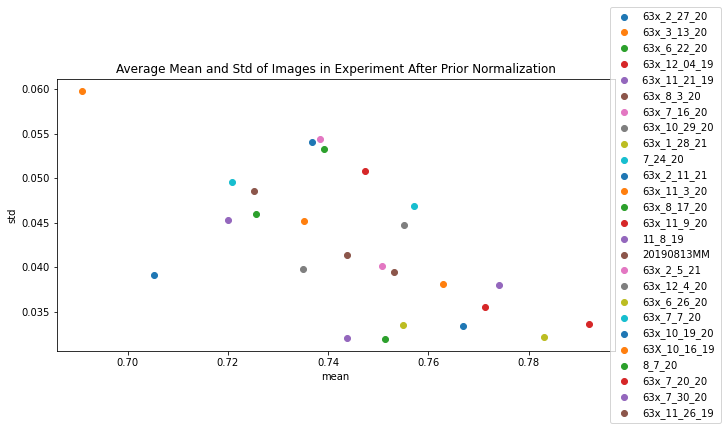

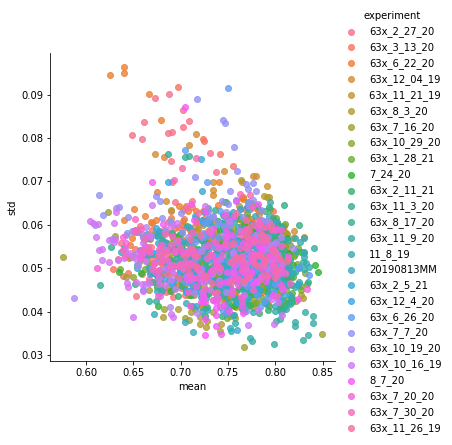

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
f, ( ax2) = plt.subplots(1, figsize = (10,5))
 
for i in expvaldf_average.index:
    ax2.scatter(expvaldf_average.iloc[i]['mean'],expvaldf_average.iloc[i]['std'])
ax2.legend(expvaldf_average['experiment'], loc = 'right', bbox_to_anchor=(.7, 0., 0.5, 1))

ax2.set_xlabel('mean')
ax2.set_ylabel('std')
ax2.set_title('Average Mean and Std of Images in Experiment After Prior Normalization')

sns.lmplot('mean', 'std', data=expvaldf, hue='experiment', fit_reg=False)
plt.show()
plt.tight_layout()

## Make the Training Data 

In [ ]:
# loading in your dataset from the DataFrame
#train_set, mask_stack1 = loaddata(traindf,path1,path2 ) # default turns images to 40X40 unless resize is changed 
df = traindf
train_dataset =imageDataGenerator() # increasing dataset 8 fold

del df

#val_set, mask_stack2  = loaddata(testdf,path1,path2 )
df = testdf
test_dataset =imageDataGenerator() # increasing dataset 8 fold
del df

batch_size =5 #dividng your whole data in batches 
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
}
 
# seperating the dataset
train_loader = dataloaders['train'] 
test_loader = dataloaders['val'] 

torch.Size([5, 1, 512, 512]) torch.Size([5, 1, 512, 512])
label tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])


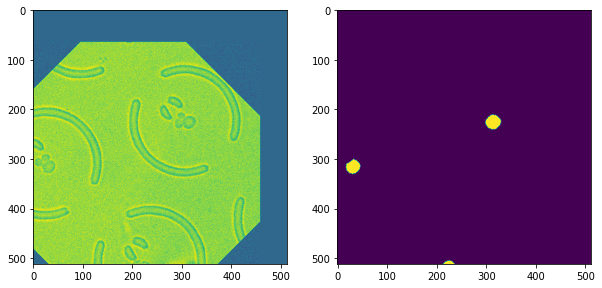

In [ ]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))
#plt.imshow(inputs[0][0] )
print('label', masks[0])
ax1.imshow(inputs[0][0])
ax2.imshow(masks[0][0])

 

#https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

model = UNET(1,2) # 1 is for how many channels 2 is for how many it outputs i said 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#https://theaisummer.com/unet-architectures/

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [ ]:
model = Unet(1,2)

In [ ]:
from typing import Tuple, Dict
import torch.nn as nn
import torch.nn.functional as F
import torch

#https://github.com/j-sripad/mulitresunet-pytorch
#https://arxiv.org/pdf/1902.04049.pdf
#https://github.com/kim-younghan/MultiResUNet


class Multiresblock(nn.Module):
  def __init__(self,input_features : int, corresponding_unet_filters : int ,alpha : float =1.67)->None:
    """
        MultiResblock
        Arguments:
          x - input layer
          corresponding_unet_filters - Unet filters for the same stage
          alpha - 1.67 - factor used in the paper to dervie number of filters for multiresunet filters from Unet filters
        Returns - None
    """ 
    super().__init__()
    self.corresponding_unet_filters = corresponding_unet_filters
    self.alpha = alpha
    self.W = corresponding_unet_filters * alpha
    self.conv2d_bn_1x1 = Conv2d_batchnorm(input_features=input_features,num_of_filters = int(self.W*0.167)+int(self.W*0.333)+int(self.W*0.5),
    kernel_size = (1,1),activation='None',padding = 0)

    self.conv2d_bn_3x3 = Conv2d_batchnorm(input_features=input_features,num_of_filters = int(self.W*0.167),
    kernel_size = (3,3),activation='relu',padding = 1)
    self.conv2d_bn_5x5 = Conv2d_batchnorm(input_features=int(self.W*0.167),num_of_filters = int(self.W*0.333),
    kernel_size = (3,3),activation='relu',padding = 1)
    self.conv2d_bn_7x7 = Conv2d_batchnorm(input_features=int(self.W*0.333),num_of_filters = int(self.W*0.5),
    kernel_size = (3,3),activation='relu',padding = 1)
    self.batch_norm1 = nn.BatchNorm2d(int(self.W*0.5)+int(self.W*0.167)+int(self.W*0.333) ,affine=False)

  def forward(self,x: torch.Tensor)->torch.Tensor:

    temp = self.conv2d_bn_1x1(x)
    a = self.conv2d_bn_3x3(x)
    b = self.conv2d_bn_5x5(a)
    c = self.conv2d_bn_7x7(b)
    x = torch.cat([a,b,c],axis=1)
    x = self.batch_norm1(x)
    x += temp
    x = self.batch_norm1(x)
    return x

class Conv2d_batchnorm(nn.Module):
  def __init__(self,input_features : int,num_of_filters : int ,kernel_size : Tuple = (2,2),stride : Tuple = (1,1), activation : str = 'relu',padding  : int= 0)->None:
    """
    Arguments:
      x - input layer
      num_of_filters - no. of filter outputs
      filters - shape of the filters to be used
      stride - stride dimension 
      activation -activation function to be used
    Returns - None
    """
    super().__init__()
    self.activation = activation
    self.conv1 = nn.Conv2d(in_channels=input_features,out_channels=num_of_filters,kernel_size=kernel_size,stride=stride,padding = padding)
    self.batchnorm = nn.BatchNorm2d(num_of_filters,affine=False)
  
  def forward(self,x : torch.Tensor)->torch.Tensor:
    x = self.conv1(x)
    x = self.batchnorm(x)
    if self.activation == 'relu':
      return F.relu(x)
    else:
      return x


class Respath(nn.Module):
  def __init__(self,input_features : int,filters : int,respath_length : int)->None:
    """
    Arguments:
    input_features - input layer filters
    filters - output channels
    respath_length - length of the Respath
    
    Returns - None
    """
    super().__init__()
    self.filters = filters
    self.respath_length = respath_length
    self.conv2d_bn_1x1 = Conv2d_batchnorm(input_features=input_features,num_of_filters = self.filters,
    kernel_size = (1,1),activation='None',padding = 0)
    self.conv2d_bn_3x3 = Conv2d_batchnorm(input_features=input_features,num_of_filters = self.filters,
    kernel_size = (3,3),activation='relu',padding = 1)
    self.conv2d_bn_1x1_common = Conv2d_batchnorm(input_features=self.filters,num_of_filters = self.filters,
    kernel_size = (1,1),activation='None',padding = 0)
    self.conv2d_bn_3x3_common = Conv2d_batchnorm(input_features=self.filters,num_of_filters = self.filters,
    kernel_size = (3,3),activation='relu',padding = 1)
    self.batch_norm1 = nn.BatchNorm2d(filters,affine=False)
    
  def forward(self,x : torch.Tensor)->torch.Tensor:
    shortcut = self.conv2d_bn_1x1(x)
    x = self.conv2d_bn_3x3(x)
    x += shortcut    
    x = F.relu(x)
    x = self.batch_norm1(x)
    if self.respath_length>1:
      for i in range(self.respath_length):
        shortcut = self.conv2d_bn_1x1_common(x)
        x = self.conv2d_bn_3x3_common(x)
        x += shortcut
        x = F.relu(x)
        x = self.batch_norm1(x)
      return x
    else:
      return x

class MultiResUnet(nn.Module):
  def __init__(self,channels : int,filters : int =32,nclasses : int =1)->None:

    """
    Arguments:
    channels - input image channels
    filters - filters to begin with (Unet)
    nclasses - number of classes
    Returns - None
    """
    super().__init__()
    self.alpha = 1.67
    self.filters = filters
    self.nclasses = nclasses
    self.multiresblock1 = Multiresblock(input_features=channels,corresponding_unet_filters=self.filters)
    self.pool1 =  nn.MaxPool2d(2,stride= 2)
    self.in_filters1 = int(self.filters*self.alpha* 0.5)+int(self.filters*self.alpha*0.167)+int(self.filters*self.alpha*0.333)
    self.respath1 = Respath(input_features=self.in_filters1 ,filters=self.filters,respath_length=4)
    self.multiresblock2 = Multiresblock(input_features= self.in_filters1,corresponding_unet_filters=self.filters*2)
    self.pool2 =  nn.MaxPool2d(2, 2)
    self.in_filters2 = int(self.filters*2*self.alpha* 0.5)+int(self.filters*2*self.alpha*0.167)+int(self.filters*2*self.alpha*0.333)
    self.respath2 = Respath(input_features=self.in_filters2,filters=self.filters*2,respath_length=3)
    self.multiresblock3 = Multiresblock(input_features= self.in_filters2,corresponding_unet_filters=self.filters*4)
    self.pool3 =  nn.MaxPool2d(2, 2)
    self.in_filters3 = int(self.filters*4*self.alpha* 0.5)+int(self.filters*4*self.alpha*0.167)+int(self.filters*4*self.alpha*0.333)
    self.respath3 = Respath(input_features=self.in_filters3,filters=self.filters*4,respath_length=2)
    self.multiresblock4 = Multiresblock(input_features= self.in_filters3,corresponding_unet_filters=self.filters*8)
    self.pool4 =  nn.MaxPool2d(2, 2)
    self.in_filters4 = int(self.filters*8*self.alpha* 0.5)+int(self.filters*8*self.alpha*0.167)+int(self.filters*8*self.alpha*0.333)
    self.respath4 = Respath(input_features=self.in_filters4,filters=self.filters*8,respath_length=1)
    self.multiresblock5 = Multiresblock(input_features= self.in_filters4,corresponding_unet_filters=self.filters*16)
    self.in_filters5 = int(self.filters*16*self.alpha* 0.5)+int(self.filters*16*self.alpha*0.167)+int(self.filters*16*self.alpha*0.333)
     
    #Decoder path
    self.upsample6 = nn.ConvTranspose2d(in_channels=self.in_filters5,out_channels=self.filters*8,kernel_size=(2,2),stride=(2,2),padding = 0)  
    self.concat_filters1 = self.filters*8+self.filters*8
    self.multiresblock6 = Multiresblock(input_features=self.concat_filters1,corresponding_unet_filters=self.filters*8)
    self.in_filters6 = int(self.filters*8*self.alpha* 0.5)+int(self.filters*8*self.alpha*0.167)+int(self.filters*8*self.alpha*0.333)
    self.upsample7 = nn.ConvTranspose2d(in_channels=self.in_filters6,out_channels=self.filters*4,kernel_size=(2,2),stride=(2,2),padding = 0)  
    self.concat_filters2 = self.filters*4+self.filters*4
    self.multiresblock7 = Multiresblock(input_features=self.concat_filters2,corresponding_unet_filters=self.filters*4)
    self.in_filters7 = int(self.filters*4*self.alpha* 0.5)+int(self.filters*4*self.alpha*0.167)+int(self.filters*4*self.alpha*0.333)
    self.upsample8 = nn.ConvTranspose2d(in_channels=self.in_filters7,out_channels=self.filters*2,kernel_size=(2,2),stride=(2,2),padding = 0)  
    self.concat_filters3 = self.filters*2+self.filters*2
    self.multiresblock8 = Multiresblock(input_features=self.concat_filters3,corresponding_unet_filters=self.filters*2)
    self.in_filters8 = int(self.filters*2*self.alpha* 0.5)+int(self.filters*2*self.alpha*0.167)+int(self.filters*2*self.alpha*0.333)
    self.upsample9 = nn.ConvTranspose2d(in_channels=self.in_filters8,out_channels=self.filters,kernel_size=(2,2),stride=(2,2),padding = 0)  
    self.concat_filters4 = self.filters+self.filters
    self.multiresblock9 = Multiresblock(input_features=self.concat_filters4,corresponding_unet_filters=self.filters)
    self.in_filters9 = int(self.filters*self.alpha* 0.5)+int(self.filters*self.alpha*0.167)+int(self.filters*self.alpha*0.333)
    self.conv_final = Conv2d_batchnorm(input_features=self.in_filters9,num_of_filters = self.nclasses,
    kernel_size = (1,1),activation='None')

  def forward(self,x : torch.Tensor)->torch.Tensor:
    x_multires1 = self.multiresblock1(x)
    x_pool1 = self.pool1(x_multires1)
    x_multires1 = self.respath1(x_multires1)
    x_multires2 = self.multiresblock2(x_pool1)
    x_pool2 = self.pool2(x_multires2)
    x_multires2 = self.respath2(x_multires2)
    x_multires3 = self.multiresblock3(x_pool2)
    x_pool3 = self.pool3(x_multires3)
    x_multires3 = self.respath3(x_multires3)
    x_multires4 = self.multiresblock4(x_pool3)
    x_pool4 = self.pool4(x_multires4)
    x_multires4 = self.respath4(x_multires4)
    x_multires5 = self.multiresblock5(x_pool4)
    up6 = torch.cat([self.upsample6(x_multires5),x_multires4],axis=1)
    x_multires6 = self.multiresblock6(up6)
    up7 = torch.cat([self.upsample7(x_multires6),x_multires3],axis=1)
    x_multires7 = self.multiresblock7(up7)
    up8 = torch.cat([self.upsample8(x_multires7),x_multires2],axis=1)
    x_multires8 = self.multiresblock8(up8)
    up9 = torch.cat([self.upsample9(x_multires8),x_multires1],axis=1)
    x_multires9 = self.multiresblock9(up9)
    if self.nclasses > 1:
      conv_final_layer =  self.conv_final(x_multires9)
    else:
      conv_final_layer =  torch.sigmoid(self.conv_final(x_multires9))
    return conv_final_layer

model = MultiResUnet(channels=1,filters=16,nclasses=2)

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device('cpu')

print('device used {}'.format(device))

In [ ]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.to(device)

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                # normalizing by the batch 
                #x -= x.min() # bring the lower range to 0
                #x /= x.max() # bring the upper range to 1
                
                x = x.to(device).float() # to avoid the stupid double tensor problem 
                y = y.to(device).float()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)#.type(torch.torch.long)
                    outputs= outputs[:,1,:,:]
                    loss = loss_fn(outputs , y.squeeze(1).float() ) # squeeze the mask bc it is [batch,1,512,512], squezzing removes the 1 and makes it only one channel so it is [batch,512,512]

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        outputs= outputs[:,1,:,:]
                        loss = loss_fn(outputs, y.squeeze(1).float()) # squeeze the mask bc it is [batch,1,512,512], squezzing removes the 1 and makes it only one channel so it is [batch,512,512]

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                #if step % 10 == 0:
                    # clear_output(wait=True)
                    #print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    '''use this to calculate accuracy if using the nn.CrossEntropyLoss() '''
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

def acc_metric(y_pred, y_test):
    '''use this to calculate accuracy if using the nn.BCEWithLogitsLoss()'''
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
loss_fn =  nn.BCEWithLogitsLoss()#nn.CrossEntropyLoss()  # nn.CrossEntropyLoss()  nn.BCELoss() # 
opt =  torch.optim.Adam(model.parameters(), lr = .001)
train_loss, valid_loss = train(model,train_loader,test_loader, loss_fn, opt, acc_metric, epochs = 50)

Epoch 0/49
----------
train Loss: 0.7007 Acc: 58463756.0
valid Loss: 0.6905 Acc: 98356792.0
Epoch 1/49
----------
train Loss: 0.6989 Acc: 49265588.0
valid Loss: 0.6908 Acc: 74822136.0
Epoch 2/49
----------
train Loss: 0.6952 Acc: 73628376.0
valid Loss: 0.7039 Acc: 44336848.0
Epoch 3/49
----------
train Loss: 0.6927 Acc: 87103608.0
valid Loss: 0.7051 Acc: 87038576.0
Epoch 4/49
----------
train Loss: 0.6638 Acc: 123094720.0
valid Loss: 0.6543 Acc: 128154312.0
Epoch 5/49
----------
train Loss: 0.6548 Acc: 128209864.0
valid Loss: 0.6713 Acc: 120869632.0
Epoch 6/49
----------
train Loss: 0.6530 Acc: 128498952.0
valid Loss: 0.6811 Acc: 95443344.0
Epoch 7/49
----------
train Loss: 0.6522 Acc: 128648176.0
valid Loss: 0.6742 Acc: 118698440.0
Epoch 8/49
----------
train Loss: 0.6517 Acc: 128739464.0
valid Loss: 0.6771 Acc: 120415104.0
Epoch 9/49
----------
train Loss: 0.6512 Acc: 128787448.0
valid Loss: 0.6752 Acc: 122128408.0
Epoch 10/49
----------
train Loss: 0.6513 Acc: 128766752.0
valid Loss

In [ ]:
## Saving the model 
name ='MultiresUNET_512_512' #'UNET_512_512'#'MCunet2'#'63MMD_VAE_volThresh'#'MMD_VAE_Binary'  # 'MMD_VAE_volThresh' - using volthresh and mmd vae  #MMD_VAE_preBinary_volthresh
torch.save(model.state_dict(), path+'/{}.pth'.format(name)) 

train = pd.DataFrame(train_loss)
valid = pd.DataFrame(valid_loss)

train.to_csv('train_{}'.format(name), sep = '\t')

valid.to_csv('valid_{}'.format(name), sep = '\t')
 

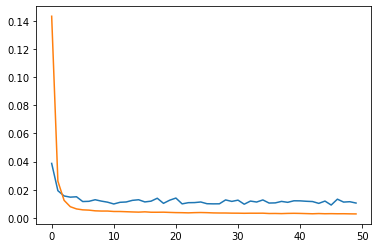

In [ ]:
plt.plot(valid)
plt.plot(train)

In [ ]:
name ='UNET_512_512'#'MMD_VAE_preBinary_volthresh' #'63MMD_VAE_volThresh' #'MMD_VAE_preBinary_volthresh' #MMD_VAE_Binary MMD_VAE_preBinary_volthresh
model.load_state_dict(torch.load(path+'/{}.pth'.format(name), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model.to(device) # will turn model for GPU or CPU depending on the device stated above
model.eval()

torch.Size([5, 1, 512, 512]) torch.Size([5, 1, 512, 512])
label tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])


torch.Size([5, 1, 512, 512])

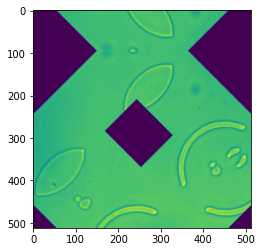

In [ ]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
#f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))
plt.imshow(inputs[0][0] )
print('label', masks[0])
#ax1.imshow(inputs[0][0])
#ax2.imshow(masks[0][0])

# grab a batch from the train loader
batch, classes = next(iter(train_loader))
batch.shape

In [ ]:
pred = model(inputs.to(device) ).to('cpu').detach().numpy()

In [ ]:
pred.shape

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,20))
samp =4
ax1.imshow(inputs[samp,0,:,:])
ax2.imshow(masks[samp,:,:])

thresh = pred[samp,1,:,:].mean() + (4 * (pred[samp, 1, :,:]).std())

mask = pred[samp, 1, :,:] >= thresh
mask1 = ndi.binary_dilation(ndi.gaussian_filter(mask, sigma = 1), iterations=2)

ax3.imshow(mask)


ax4.imshow(inputs[samp,0,:,:])

contours = find_contours(mask1, .5) # finds the corresponding peaks and draws it on the picture
for contour in contours:
    
   ax4.plot(contour[:, 1], contour[:, 0], linewidth=2, color='b')

In [ ]:
?ndi.binary_dilation

In [ ]:
mask1

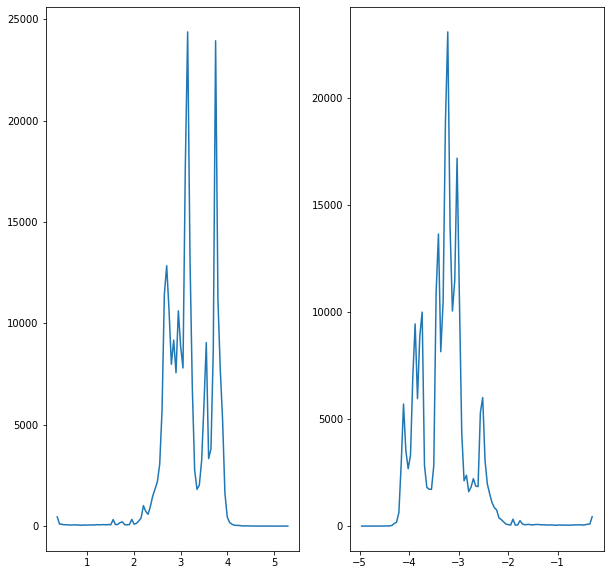

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

hist, bins = np.histogram(pred[samp,0,:,:].ravel(), 100)
ax1.plot(bins[1:], hist)
hist, bins = np.histogram(pred[samp,1,:,:].ravel(), 100)
ax2.plot(bins[1:], hist)

In [ ]:
!wget http:/~michael/11_8_19.tar.gz -P /drive/STRP
!mkdir /drive/STRP/hsp/
!tar xvf /drive/STRP/11_8_19.tar.gz -C /drive/STRP/hsp

In [ ]:
bf_images =  getFileList ('/drive/mother_data/bf' +'/*c1_ORG.tif')
rfp_images  =  getFileList ('/drive/mother_data/bf' +'/*c1_ORG.tif')
gfp_images  =  getFileList('/drive/mother_data/bf' +'/*c1_ORG.tif')

In [ ]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def gausmix(df,mask):
    """This is to calculate the GFP max using Gaussian mixture model,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """
    
    X =   df[mask].reshape(df[mask].shape[0],1) # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.GaussianMixture(n_components=2).fit(X) 
    maxgmm = np.max(gmm.means_)
    mingmm = np.min(gmm.means_)
    return maxgmm, mingmm  # returns the mixture component greatest min

In [ ]:
sorted(list(rfp_images[pos].keys() ) )[-5:]

[55, 56, 57, 58, 59]

In [ ]:

transform = transforms.ToTensor() # for transformation
 

for pos in sorted(rfp_images.keys()):
  for time in sorted(list(rfp_images[pos].keys() ) )[:3]:

    # creating unique labels
    referenceimgbfp = skimage.io.imread(bf_images[pos][1][0])
    
    unalignbf = skimage.io.imread(bf_images[pos][time][0]) #quickaggre(pos, time , bf_images, False)[pos][time]  

    shift, error, diffphase = register_translation(referenceimgbfp, unalignbf, 1000)# using original bf_aggre to calculate shift
    alginimgbf = np.roll(unalignbf, int(shift[0]), axis = 0)# switched out unaliginbf 
    alginimgBF = np.roll(alginimgbf, int(shift[1]), axis = 1)


    #alginimgBF = (rotate(alginimgBF, angle = 270) )


    bfimage1 = alginimgBF  #quickaggre(pos, 1 , bf_images, False)[pos][1] # read all zstacks of brightfield 
    bfimage = (bfimage1 - np.min(bfimage1))/(np.max(bfimage1) - np.min(bfimage1))# normalize merged zstacks to 0-1
    bftensor = transform(bfimage.astype(np.float32)) # turn into tensor format 
    with torch.no_grad(): # will speed it up
      predict = model(bftensor.to(device).view(-1,1, 512,512) ).to('cpu').detach().numpy()

    pred = predict[0,1,:,:].reshape(512,512)
    thresh =   pred.mean() + (4* (pred).std())
    mask = pred >= thresh
    mask = ndi.binary_dilation(ndi.gaussian_filter(mask, sigma = 1), iterations=2)

    reflabel = skimage.morphology.label(mask)


    print(pos, time)
    f, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (20,20))
    ax1.imshow(alginimgBF)
    ax2.imshow(mask)
    ax3.imshow(alginimgBF )
    contours = find_contours(mask, .5) # finds the corresponding peaks and draws it on the picture
    for contour in contours:
        
        ax3.plot(contour[:, 1], contour[:, 0], linewidth=2, color='b')

    plt.show()

In [ ]:
'Calculating max intensity for GFP and RFP of each individual cell. This will take the position and time into account'
# making a dataframe that will be used for position and time 
import time as Time
from skimage.morphology import remove_small_objects
from skimage.measure import find_contours
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
import pylab
from skimage.segmentation import flood 
import cv2
import numpy as np

transform = transforms.ToTensor() # for transformation

gfplist = []
gfp_sumlist = []
gfpGMmaxlist = []
gfpGMminlist = []
gfplistori = []
gfp_sumlistori = []
gfpGMmaxlistori = []
gfpGMminlistori = []
rfplist = []
rfpsumlist = []
rfpGMmaxlist = []
rfpGMminlist = []
failpos = []
areamasklist = []
proteinarealist = []
failrfp =[]
infolist = []
for pos in sorted(rfp_images.keys()):
    # creating unique labels
    pos = '003'
    referenceimg = None
    bfimage1 = skimage.io.imread(bf_images[pos][1][0])  #quickaggre(pos, 1 , bf_images, False)[pos][1] # read all zstacks of brightfield 
    bfimage = (bfimage1 - np.min(bfimage1))/np.max(bfimage1)# normalize merged zstacks to 0-1
    bftensor = transform(bfimage.astype(np.float32)) # turn into tensor format 
    with torch.no_grad(): # will speed it up
      predict = model(bftensor.to(device).view(-1,1, 512,512) ).to('cpu').detach().numpy()

    pred = predict[0,1,:,:].reshape(512,512)
    thresh =   pred.mean() + (4.2* (pred).std())
    mask = pred >= thresh
    mask = remove_small_objects(mask, min_size=100)
    maskori = mask #ndi.binary_dilation(ndi.gaussian_filter(mask, sigma = 1), iterations=1)

    reflabel = skimage.morphology.label(maskori)
    plt.imshow(reflabel )
    plt.title(pos)
 
    plt.show()
    for mother in np.unique(reflabel): # all mother cells found are based on RFP first time point
        if mother == 0: # is the background so we get rid of it
            continue
        print('mother sum ', np.sum(mother))
        prev_roi = mother
        prev_mask = None
        referenceimg = None
        prev_area = None
        mask = maskori # we need to blank the mask back to the original so that every cell is referenced back to the original mask. can't do later as it backfires!
        #maskquant= None # blanking for future
        for time in sorted( rfp_images[pos]):

            if referenceimg is None: # making all images to align to the reference image of 1
                referenceimg = 'filled'#quickaggre(pos, 1 , rfp_images, False)[pos][1] #rfp_aggre[pos][1].copy()
                referenceimgbfp = skimage.io.imread(bf_images[pos][1][0]) #quickaggre(pos, 1 , bf_images, False)[pos][1]  #bf_aggre[pos][1].copy() #netbf[pos][1].copy() #
                continue 

            # shifting and aligning the next images
                     # Shifting GFP alignment 
            unalignbf = skimage.io.imread(bf_images[pos][time][0]) #quickaggre(pos, time , bf_images, False)[pos][time]  
            shift, error, diffphase = register_translation(referenceimgbfp, unalignbf, 1000)# using original bf_aggre to calculate shift
            alginimgbf = np.roll(unalignbf, int(shift[0]), axis = 0)# switched out unaliginbf 
            alginimgBF = np.roll(alginimgbf, int(shift[1]), axis = 1)
            
            # shifting RFP
            unalignrfp = skimage.io.imread(bf_images[pos][time][0]) # quickaggre(pos, time , rfp_images, False)[pos][time] #rfp_aggre[pos][time].copy()
            alginimgrfp = np.roll(unalignrfp, int(shift[0]), axis = 0)
            alginimgRFP =  np.roll(alginimgrfp, int(shift[1]), axis = 1)

                # Shifting GFP alignment 
            unaligngfp = skimage.io.imread(bf_images[pos][time][0]) #quickaggre(pos, time, gfp_images, False, True)[pos][time] #gfp_gaus[pos][time].copy()
            alginimggfp = np.roll(unaligngfp, int(shift[0]), axis = 0)
            alginimgGFP = np.roll(alginimggfp, int(shift[1]), axis = 1)
            
             # Shifting original GFP alignment 
            unaligngfpori = skimage.io.imread(bf_images[pos][time][0]) #quickaggre(pos, time, gfp_images, False)[pos][time] #gfp_aggre[pos][time].copy()
            alginimggfpori = np.roll(unaligngfpori, int(shift[0]), axis = 0)
            alginimgGFPori = np.roll(alginimggfpori, int(shift[1]), axis = 1)
                 
            
            if prev_mask is None: # First frame WILL be used only!
                prev_mask = mask # setting up the first original mask to restart each time
                check = None
 
                #continue
            
            else:
              bfimage1 = alginimgBF.copy()
              bfimage = (bfimage1 - np.min(bfimage1))/np.max(bfimage1)# normalize merged zstacks to 0-1
              bftensor = transform(bfimage.astype(np.float32))
              with torch.no_grad(): # will speed it up
                predict = model(bftensor.to(device).view(-1,1, 512,512)).to('cpu').detach().numpy()
              
              pred = predict[0,1,:,:].reshape(512,512)
              thresh = pred.mean()  + (4.5* (pred).std())
              mask = pred >= thresh
              mask = remove_small_objects(mask, min_size=100)

            # here we are setting up the previous mask and the current mask 
            label1 = skimage.morphology.label(prev_mask) # NDI label
            label2 = skimage.morphology.label(mask)

            roi_mask1 = label1 == prev_roi
            best_roi = -1
            best_sum = 0
            plt.imshow(label2)
            plt.show()
            for i in np.unique(label2):
                if i == 0:  # is the background so we get rid of it
                    continue
                if len(regionprops(label2))>0 : # to remove any frame that has no cells 
                    roi_mask2 = label2 == i # selecting the mask of the previous frame 
                    roi_sum = np.sum(roi_mask1*roi_mask2) # multiplying the masks to shift it 
                    if roi_sum > best_sum:
                        best_sum = roi_sum
                        best_roi = i

                        #prev_roi = best_roi
            if (best_roi > 0):
                #maskquant= label2 == best_roi
                    # making the mask
                try:
                    maskquant = label2 == best_roi # the mask used to pick the cell we want 
                    maskquant2 = scipy.ndimage.morphology.binary_dilation(maskquant, iterations=1) 
                    area = np.sum(maskquant)
 
                    if check is None:
                        prev_area = np.sum(maskquant2)  
                        precircle= None
                    check = regionprops(label(maskquant))
                    for circle in check:
                        if precircle is None:
                          precircle = circle 

                        print('HELLO','circle eccentricty {}'.format(circle.eccentricity), 'precircle {}'.format(precircle.eccentricity), 'area {}'.format(area), 'prearea {}'.format(prev_area))
                        if (area> (1.3 *prev_area) ) or (area< (.85 *prev_area) ) or (circle.eccentricity < (.5*precircle.eccentricity)): 
                          maskquant = label1 == prev_roi # switching out to the previous mask which is label1 with the previous roi
                          best_roi = prev_roi
                          mask = prev_mask
                          circle = precircle

                          print('FAILURE','circle eccentricty {}'.format(circle.eccentricity), 'precircle {}'.format(precircle.eccentricity), 'area {}'.format(area), 'prearea {}'.format(prev_area))
                          if (area> (1.3 *prev_area) ):
                            print('area was too big')
                          if (area< (.9 *prev_area) ):
                            print('area was too small')
                          if (circle.eccentricity < (.88*precircle.eccentricity)):
                            print('not circular')

                          if np.sum(label2 == best_roi) <= 1:
                            best_roi = prev_roi
                        maskquant2 = scipy.ndimage.morphology.binary_dilation(maskquant, iterations=2) # to get the RFP signal
                        area = np.sum(maskquant)


                  

                except:
                    pass 
            
 
 
            print(pos, time)
            f, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (20,20))
            ax1.imshow(alginimgBF)
            ax2.imshow(maskquant)
            ax3.imshow(alginimgBF )
            contours = find_contours(maskquant, .5) # finds the corresponding peaks and draws it on the picture
            for contour in contours:
                
                ax3.plot(contour[:, 1], contour[:, 0], linewidth=.8, color='b')

            plt.show()
            if best_roi < 0:
                failpos.append([str(pos) + '_cell_' +str(mother)+'time_'+str(time)])
                

           #calculating the values
            position = 'pos' + '_'+ str(pos) + '_cell_' +str(mother)
            timepoint = time
            

            #rfp_pixmax = np.max(alginimgRFP[maskquant2])
            #rfp_pixsum = np.sum(alginimgRFP[maskquant2])
            #rfp_pixGMmax, rfp_pixGMmin =gausmix(alginimgRFP,maskquant2)# gaussian mixture function
            
            #gfp_pixmax = np.max(alginimgGFP[maskquant])
            #gfp_pixsum = np.sum(alginimgGFP[maskquant])
            #gfp_pixGMmax, gfp_pixGMmin = gausmix(alginimgGFP,maskquant)# gaussian mixture function
            
            #gfp_pixmaxori = np.max(alginimgGFPori[maskquant])
            #gfp_pixsumori = np.sum(alginimgGFPori[maskquant])
            #gfp_pixGMmaxori, gfp_pixGMminori = gausmix(alginimgGFPori,maskquant)

            #gfplist.append([position,timepoint,gfp_pixmax])
            #gfp_sumlist.append([position,timepoint,gfp_pixsum])
            #gfpGMmaxlist.append([position,timepoint,gfp_pixGMmax])# mean max pixel after Gaus mixture model
            #gfpGMminlist.append([position,timepoint,gfp_pixGMmin])
            
            #gfplistori.append([position,timepoint,gfp_pixmaxori])
            #gfp_sumlistori.append([position,timepoint,gfp_pixsumori])
            #gfpGMmaxlistori.append([position,timepoint,gfp_pixGMmaxori])# mean max pixel after Gaus mixture model
            #gfpGMminlistori.append([position,timepoint,gfp_pixGMminori])
            
            #rfplist.append([position,timepoint,rfp_pixmax])# max
            #rfpsumlist.append([position,timepoint,rfp_pixsum]) # sum
            #rfpGMmaxlist.append([position,timepoint,rfp_pixGMmax]) # mean max pixel after Gaus mixture model
            #rfpGMminlist.append([position,timepoint,rfp_pixGMmin])
                #calculating cell area and how much space a protein or organelle is occupying            
            #proteinarea = alginimgGFP.copy()
            try:
                proteinarea = proteinarea> threshold_otsu(proteinarea[maskquant]) # also servers as a normalize comparing 0,1
            except:
                pass
            #proteinarea  = np.sum(proteinarea[maskquant]) # pixel NOT being measured it is sum of TRUEs
            
            #proteinarealist.append([position,timepoint,proteinarea])
            #areamasklist.append([position,timepoint,area]) # for cell
            
            infolist.append([position, timepoint, area, shift,circle.eccentricity, circle.centroid[0],circle.centroid[1], circle.coords ])

            if (best_roi > 0): # best roi will be -1 if the label2 has a shitty image
                prev_roi = best_roi # to replace 
                prev_mask = mask
                prev_area = area
                check = regionprops(label(maskquant))
                precircle = circle 


            #if time > 41: break
 
end = Time.time()
print((end-start)/60, 'minutes to run')
    
del referenceimg, referenceimgbfp, unalignbf, unalignrfp,unaligngfp,unaligngfpori

In [ ]:
roi_mask2 = label2 == i # selecting the mask of the previous frame 
  roi_sum = np.sum(roi_mask1*roi_mask2) # multiplying the masks to shift it 
  if roi_sum > best_sum:
      best_sum = roi_sum
      best_roi = i

3